### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [48]:
import numpy as np
import itertools

example_matrix = np.array([[1.5, 0.5], [0.5, 1.5]])
big_example_matrix = np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 0, 0, 3]])

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.45 0.05 0.05 0.45]


as an example, whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

Note that the eigenvalues and the corresponding eigenvectors obtained by classical PCA are given by
$$\lambda_1=2, u_1=[1,1]^T$$
$$\lambda_2=1, u_2=[−1,1]^T.$$

Note: $[1, 0]^T = |0〉$ and $[0, 1]^T = |1〉.$ 

When we take a threshold τ=1.1 for eigenvalues, the eigenvalue in binary $|λ_1〉=|10〉$ and the corresponding eigenvector $|u_1〉=[1,1]^T=\frac{1}{\sqrt{2}}|0〉+\frac{1}{\sqrt{2}}|1〉$ are considered as principal components. Therefore, the output of the proposed algorithm should be given by

$$\begin{aligned}
\left|\psi_A^{\prime}\right\rangle &=\left|\lambda_1\right\rangle\left|u_1\right\rangle\left|u_1\right\rangle \\
&=|10\rangle \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \\
&=\frac{1}{2}|1000\rangle+\frac{1}{2}|1001\rangle+\frac{1}{2}|1010\rangle+\frac{1}{2}|1011\rangle .
\end{aligned}$$

In [49]:
# thetas = [2 * np.arcsin(np.sqrt(input_probabilities[1]+input_probabilities[2])), 2 * np.arcsin(np.sqrt(input_probabilities[0]+input_probabilities[3]))]
# thetas

In [50]:
#Tommaso's great code for computing the thetas

lst_combination=[]

for k in range(1, len(example_matrix)+1):
    lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
container=[]
for lst in lst_combination:
    container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
all_combinations=[item for c in container for item in c]

general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=len(example_matrix))))]

#Nodes contains all the values of the tree (except for the root)
nodes=[]
for st in all_combinations:
    #print(st)
    starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
    #print(starts)
    print(st,'->',np.sqrt(input_probabilities[starts].sum()))
    nodes.append(np.sqrt(input_probabilities[starts].sum()))

#add root tree
nodes.insert(0, 1)

idx_sub=1
thetas=[]
for i in range(len(nodes)-len(input_probabilities)):
    right_node=i+idx_sub
    left_node=right_node+1
    #print(left_node,right_node)
    if nodes[i]!=0:
        #print(nodes[right_node],nodes[i])
        thetas.append(2*np.arccos(nodes[right_node]/nodes[i]))
        # thetas.append(2*np.arcsin(nodes[left_node]/nodes[i]))
    else:
        thetas.append(0)
        # thetas.append(0)
        
    idx_sub+=1

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
thetas

0 -> 0.7071067811865476
1 -> 0.7071067811865476
00 -> 0.6708203932499369
01 -> 0.22360679774997896
10 -> 0.22360679774997896
11 -> 0.6708203932499369


[1.5707963267948966, 0.6435011087932846, 2.498091544796509]

In [51]:
# Not general yet

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

resolution = 2

matrix_circuit = QuantumCircuit(len(example_matrix))

# matrix_circuit.h(0) #same as line below
matrix_circuit.ry(thetas[0], 0)
matrix_circuit.cry(thetas[1], control_qubit = 0, target_qubit = 1)
matrix_circuit.x(0)
matrix_circuit.cry(thetas[2], control_qubit = 0, target_qubit = 1)

matrix_circuit.draw()


┌─────────┐              ┌───┐              
q_0: ┤ Ry(π/2) ├──────■───────┤ X ├──────■───────
     └─────────┘┌─────┴──────┐└───┘┌─────┴──────┐
q_1: ───────────┤ Ry(0.6435) ├─────┤ Ry(2.4981) ├
                └────────────┘     └────────────┘

In [52]:
from qiskit import Aer, transpile, execute
from qiskit.visualization import plot_histogram

backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()


{'00': 0.45, '01': 0.05, '10': 0.05, '11': 0.45}

In [53]:
# from scipy.linalg import expm
# from qiskit.quantum_info.operators import Operator

# U  = expm(big_matrix*(2*np.pi*1j/4))
# np.set_printoptions(suppress=True)
# operator_U = Operator(U)
# operator_U

In [54]:
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix

unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/4)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

Operator([[-0.5+0.5j, -0.5-0.5j],
          [-0.5-0.5j, -0.5+0.5j]],
         input_dims=(2,), output_dims=(2,))

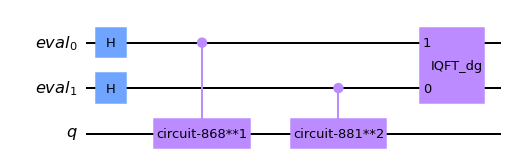

In [55]:
from qiskit.circuit.library import PhaseEstimation

pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose(reps=1).draw("mpl")

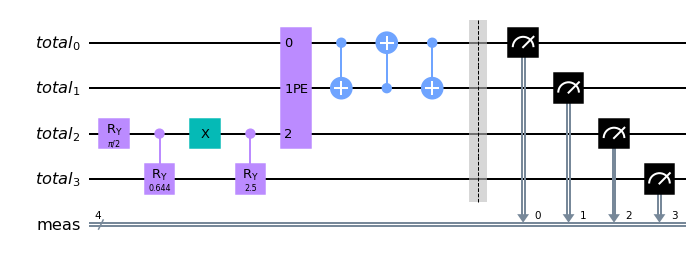

In [56]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[2:])
total_circuit.append(pe.to_gate(), qr_total[0:3])
# total_circuit.measure(qr_total[:2], classical[:])
total_circuit.swap(qr_total[0],qr_total[1])
total_circuit.measure_all()

total_circuit.decompose(reps=1).draw("mpl")

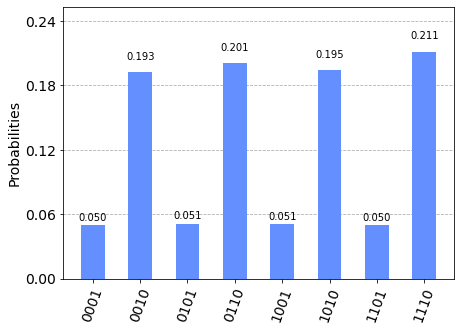

In [57]:
from qiskit.visualization import plot_histogram

backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total), shots=10000)
counts = job.result().get_counts()
plot_histogram(counts)